# Functions

In [1]:
#require("epimdr")
require("deSolve")
require("ggplot2")


beta <-function(c_r,q,d,h,epsilon){
  return(c_r * epsilon *  (( (-1 / q) * (1 - exp( q * d)))/((- 1 / q) * (1 - exp( q * d)) + h)))
}

cr_normal <- function(Climate, m , c, stype) {
  #parameters
  #m is the cooredinates where the contact rate is at a maximum 
  #c is 95 % confidence interval for duration
  #t range_C is the T values the function is calculated for
  #s type determines whether s is calculated using the upper or lower confidence interval
  c_u = c[2]
  c_l = c[1]
  m_C = m[1]
  m_cr = m[2]
  #find s
  if (stype==1){
    s = (c_u - m_C) / 1.96
  }else{
    s = -(c_l - m_C) / 1.96
  }
  #find y axis of normal distribution given s   
  scaling = sqrt(2 * pi) * s * m_cr
  
  return(scaling*(1 / (sqrt(2 * pi) * s))*exp((-(Climate - m_C) ^ 2) / (2 * s ^ 2)))
}


#this is where quantile_95 is used 
cr_climate <- function(Max_Coordinates_cr, range_C, Climate) {
  #finds the equation fiven temp_at_max and range_C. then finds S for given T
  #uses where temp at max relates to range_C to determine stype (to determine whether lower or upper value of range_C is used to find SI)
  if (abs(Max_Coordinates_cr[1]-range_C[1])>abs(Max_Coordinates_cr[1]-range_C[2])){
    stype=0
  }else{
    stype=1
  }
  #finds d at T values for given parameters (contact finds equation using duration_normal_scaled)
  #t_range_C not strictly needed 
  #return(mean_duration(T = T,m = c(temp_at_max, max_mean_contact), c = quantile_95, T_range_C = range_C, stype=stype))
  return(cr_normal(Climate = Climate,m = Max_Coordinates_cr, c = range_C, stype=stype))
  
}



q_climate <- function(q0,g, Climate) {
  return(q0*exp(g*Climate))
}



Climate_Time_Function<- function(time,min,max,time_at_peak) {
  # here, climate is varying with time at a yearly cycle.
  return((max-min)/2 * cos((2 * pi / 365)* (time - time_at_peak ) ) + (max+min)/2)
}


SEIR_model <- function(time, values, parms) {
  #function where c changes with the climate and humidity at each timepoint
  #initial values
  S <- values[1]
  E <- values[2]
  I <- values[3]
  R <- values[4]
  N <- values[5]
  #parameters
  
  for (parameter in names(parms)){
    assign(parameter,parms[[parameter]])
  }
  
  for (variable in names(Climate_Variables)){
    assign(variable,Climate_Variables[[variable]])
  }
  

  #find climate given time
  Climate <- Climate_Time_Function(time=time ,min=range_C[1],max=range_C[2],time_at_peak = time_at_peak)   
  
  cr_value=cr_climate(Climate =  Climate,Max_Coordinates_cr = c(Max_Climate_cr,Max_cr), range_C=range_C)
  q_value= q_climate(q0=q0,g=g, Climate=Climate)
  beta_value = beta(c_r = cr_value,q =q_value ,d = d,h =h ,epsilon =epsilon )    
  #seir model
  dS = nu * N - beta_value * I * S / N - mu * S + f * R
  dE = beta_value * S * I / N - (sigma + mu) * E
  dI = sigma * E - (mu + gamma) * I * (1/(1-p))
  dR = gamma * I - mu * R - f * R
  
  dN = nu * N - (p/(1-p)) *(mu + gamma) * I - mu * (S + E + I + R)
  
  
  list(c(dS, dE, dI, dR, dN))
}




plottime <- function(out) {
  #plotting seir components over time
  choose <- parms[["choose"]]
  plot(x = out[, "time"], y= out[, "S"], ylab = "Number", xlab = "Time",
       type = "l", xlim=c(min(time), max(time)),ylim=c(0,  max(out[, "N"])))
  lines(x = out[, "time"],y= out[, "E"], col = "orange")
  lines(x = out[, "time"],y= out[, "I"], col = "red",lwd=5)
  lines(x = out[, "time"],y= out[, "R"], col = "green")
  lines(x = out[, "time"],y= out[, "N"], col = "purple")  
  abline(h = max(out[,"I"]),lty=3,col="red")
  legend( "topright",legend = c("S", "E", "I", "R","N","Max I"), 
          col = c("black", "orange", "red", "green","purple","red"), lty = c(1,1,1,1,1,3), cex = 0.8)
  
  maxpercent=max(( out[, "I"]/ out[, "N"])*100)
  maximum= paste("Maximum I is:",round(maxpercent,digits = 2),"%")
  text(max(time)/2, max(out[, "N"]),maximum)

}



Loading required package: deSolve

Loading required package: ggplot2



In [11]:
latitude_data<-read.csv("../../Data/deyle_edited_summ.csv")
latitude_data<-latitude_data[which(latitude_data$variable=="T"),]
#midway through week
latitude_data$peak<-(latitude_data$peak-1)*7 +3.5
#latitude_data<-read.csv("../../Data/deyle_edited_summ.csv")
flu_data<-read.csv("../../Data/deyle_edited_summ.csv")

flu_data<-flu_data[which(flu_data$variable=="flu"),]
#midway through
#flu_data_mod<-flu_data[sort(rep(1:nrow(flu_data),len_contact)),]
flu_data$peak<-(flu_data$peak-1)*7 +3.5


In [12]:
options(repr.plot.width=4, repr.plot.height=4)

# Example series

In [13]:

#for united kingdom if mo

time = seq(0,3650, by = 0.1)
Climate_Variables= list(time_at_peak=0,range_C=c(latitude_data[77,4],latitude_data[77,5]),Max_Climate_cr=latitude_data[77,5])
parms = list( mu = 2.06e-5,sigma = 0.68 ,p = 0.005, gamma =0.25,f=0.2,
             N = 1, nu = 5.07e-5, h=0.5 / 24 ,epsilon= 0.05, d=4/24,Max_cr=29.97,climate_label="Temperature",
             g=0.085,q0=-9.079,Climate_Variables=Climate_Variables)
start = c(S = (1-1e-6)*parms[["N"]],
          I =(1e-6)*parms[["N"]],
          E = 0.00*parms[["N"]],
          R = 0*parms[["N"]],
          N  = parms[["N"]])


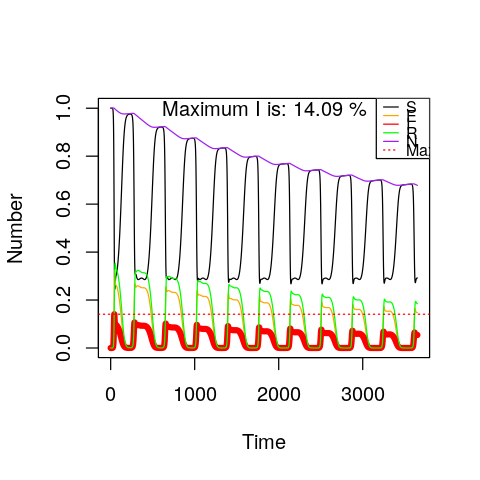

In [14]:
#if f>= 0.002 for these parameters then get annual cycles over a 10 year period. 
out = ode(    y = start,    time = time,    func = SEIR_model,    parms = parms )
plottime(out=out)

#pop size shouldnt decrease this much!
# should I change the p to 0.01?


#for important parameters (sensitivity analysis, could repeat for different values to check overall message consistent )

# Plotting mismatch and R0

In [15]:


find_R0_function<-function(Climate,parms, Climate_Variables_Temp, max_R0_Req){
  #finds r0 given temperatures where peak occurs. can use this to find maximum if max_r0_req is true
  #take variables from list to individual variables
  for (parameter in names(parms)){
    assign(parameter,parms[[parameter]])
  }
  
  for (variable in names(Climate_Variables_Temp)){
    assign(variable,Climate_Variables_Temp[[variable]])
  }
  # max_R0_req- find all or just max?
  #d and cr as functions of time
  cr_value=cr_climate(Climate =  Climate,Max_Coordinates_cr = c(Max_Climate_cr,Max_cr), range_C=range_C)
  q_value= q_climate(q0=q0,g=g, Climate=Climate)
  beta_value = beta(c_r = cr_value,q =q_value ,d = d,h =h ,epsilon =epsilon ) 

  
  #below finds the R0 at maximum if required
  #Climate[which.max((sigma / (sigma + mu)) * beta_value/(mu + alpha + gamma))]
  if (max_R0_Req =="True"){
    return(max((sigma / (sigma + mu)) * beta_value / ((mu + gamma)*( 1 / ( 1 - p)))))  

  }else{
    return(c((sigma / (sigma + mu)) * beta_value / ((mu + gamma)*( 1 / ( 1 - p )))))  
  }
}

plot_R0_mismatch<-function(parms,title, plotting_type){
  
  Climate_Variables_Temp<-parms[["Climate_Variables"]]
  
  Climate<- seq(Climate_Variables_Temp[["range_C"]][1], Climate_Variables_Temp[["range_C"]][2] , length.out = 200)   
  dataframe<-matrix(nrow=length(Climate),ncol=5)
  #loops through every climate maxima combination, finds functions which have these maxima, and uses this to find R0 as a function of time. 
  # the max of this is stored
  Climate_at_Peak_Virus <-min(Climate) 

  #because exponential growth
  for (behaviour_index in (1:length(Climate))){
    
    #set temp at maximum to the ith point in combined climate
      
      Climate_Variables_Temp[["Max_Climate_cr"]]<-Climate[behaviour_index]
  

      dataframe[behaviour_index,1]<-abs((Climate[behaviour_index] - Climate_at_Peak_Virus ) / (min(Climate) - max(Climate)))  
      dataframe[behaviour_index,2]<-find_R0_function(Climate=Climate,parms=parms,max_R0_Req="True",Climate_Variables_Temp = Climate_Variables_Temp )
      dataframe[behaviour_index,3]<-Climate[behaviour_index]
      #dataframe[behaviour_index,4]<-max(beta_value)
      dataframe[behaviour_index,5]<- Climate_at_Peak_Virus
   
    
  }
  dataframe<-as.data.frame(dataframe)
  colnames(dataframe)<-c("Mismatch","Max_R0","MaxT_cr","Max_Beta","Climate_Peak_Virus")      
  #return(dataframe)
  if (plotting_type=="ggplot"){
      return(ggplot(data=dataframe,aes(Mismatch,Max_R0))+geom_point(size=1)+theme_bw() +ggtitle(title) +ylim(0,max(dataframe[,2]))) 
  }else{
    return(plot(dataframe[,1] , dataframe[,2] , type="s" ,  main = title , ylim=c(0,12)))
  #all look a lot like this      
  }
}






R0_time_many<-function(parms,time,plotting_type, title){
  #plots R0 over time for different maxima 
  
  Climate_Variables_Temp<-parms[["Climate_Variables"]]
  
  Climate_Range<- seq(Climate_Variables_Temp[["range_C"]][1], Climate_Variables_Temp[["range_C"]][2] , length.out = 50)   
  dataframe<-matrix(nrow=length(Climate_Range)*length(time),ncol=6)
  #loops through every climate maxima combination, finds functions which have these maxima, and uses this to find R0 as a function of time. 
  # the max of this is stored
  Climate_at_Peak_Virus <-min(Climate_Range) 
  Climate_Time<-Climate_Time_Function(time=time,min = min(Climate_Range),max=max(Climate_Range),time_at_peak = Climate_Variables_Temp[["time_at_peak"]])   
  #because exponential growth
  for (behaviour_index in (1:length(Climate_Range))){
    
    #set temp at maximum to the ith point in combined climate
    
    Climate_Variables_Temp[["Max_Climate_cr"]]<-Climate_Range[behaviour_index]

    #set temp at maximum to the ith point in combined climate
    
  
      index_value<-(behaviour_index-1)*length(time)+c(1:length(time))
 
      
      dataframe[index_value,1]<-abs((Climate_Range[behaviour_index] - Climate_at_Peak_Virus ) / ( min(Climate_Range) - max(Climate_Range)))                            
      dataframe[index_value,2]<-find_R0_function(Climate=Climate_Time,parms=parms,Climate_Variables_Temp = Climate_Variables_Temp, max_R0_Req="False")
      dataframe[index_value,3]<-Climate_Range[behaviour_index]
      dataframe[index_value,5]<-time
      dataframe[index_value,6]<- Climate_at_Peak_Virus
        
        }
  #dataframe<-as.data.frame(dataframe)
  colnames(dataframe)<-c("Mismatch","R0","MaxT_cr","Max_Beta","Time","Climate_Peak_Virus")  
      
  if (plotting_type=="ggplot"){
    dataframe<-as.data.frame(dataframe)
    return(ggplot(data=dataframe,aes(Time,R0,col=Mismatch))+geom_point(size=0.02)+theme_bw() +ggtitle(title)+ylim(low=0,high=max(dataframe[,2])))   }
  if (plotting_type=="F"){
      return(dataframe)   }
  else{
    #dataframe<-as.data.frame(dataframe)
      return(plot(dataframe[,5],dataframe[,2],cex=0.2, main = title,ylim=c(0,12)))  }
  
}


In [16]:

#for united kingdom

time = seq(0,365, by = 0.1)
Climate_Variables= list(time_at_peak=180,range_C=c(latitude_data[77,4],latitude_data[77,5]),Max_Climate_cr=NA)
parms = list( mu = 2.06e-5,sigma = 0.68 ,p = 0.005, gamma =0.25,
             N = 1, nu = 5.07e-5, h=0.25 / 24 ,epsilon= 0.05, d=4/24,Max_cr=29.97,climate_label="Temperature",
             g=0.085,q0=-9.079,Climate_Variables=Climate_Variables)
start = c(S = (1-1e-3)*parms[["N"]],
          I =(1e-3)*parms[["N"]],
          E = 0.00*parms[["N"]],
          R = 0*parms[["N"]],
          N  = parms[["N"]])



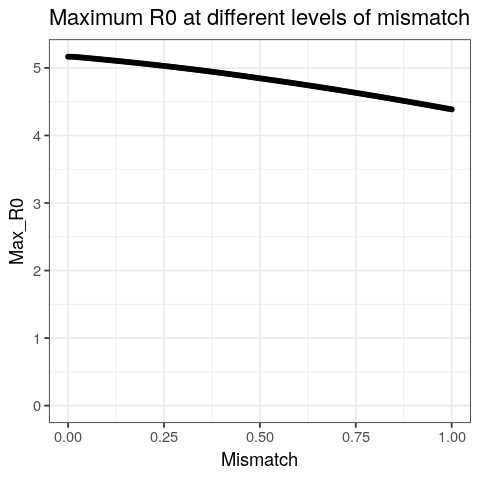

In [17]:

plot_R0_mismatch(parms=parms, plotting_type="ggplot",title="Maximum R0 at different levels of mismatch")





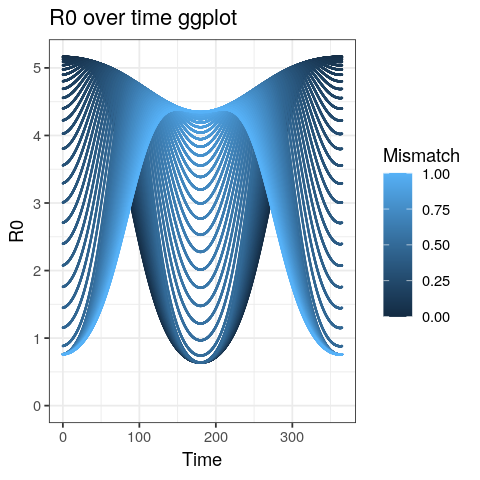

In [18]:

R0_time_many(parms=parms,time=seq(0,365,length.out = 3650), plotting_type="ggplot", title="R0 over time ggplot")



In [19]:
# Adding multuple countries

In [20]:

#for united kingdom

time = seq(0,365, by = 0.1)
Climate_Variables= list(time_at_peak=180,range_C=c(latitude_data[77,4],latitude_data[77,5]),Max_Climate_cr=NA)
parms = list( mu = 2.06e-5,sigma = 0.68 ,p = 0.005, gamma =0.25,
             N = 1, nu = 5.07e-5, h=0.25 / 24 ,epsilon= 0.05, d=4/24,Max_cr=29.97,climate_label="Temperature",
             g=0.085,q0=-9.079,Climate_Variables=Climate_Variables)
start = c(S = (1-1e-3)*parms[["N"]],
          I =(1e-3)*parms[["N"]],
          E = 0.00*parms[["N"]],
          R = 0*parms[["N"]],
          N  = parms[["N"]])



In [24]:
defaultW <- getOption("warn")
options(warn = -1)
 

parms_temp<-parms
all<-as.data.frame(matrix(ncol=ncol(latitude_data)+6))
names(all)<- c("Mismatch","R0", "MaxT_cr","Max_Beta", "Time", "Climate_Peak_Virus" ,colnames(latitude_data) )
for (i in 1:nrow(latitude_data)){
  parms_temp[["Climate_Variables"]][["range_C"]]<-c(latitude_data$low[i],latitude_data$high[i])
  parms_temp[["Climate_Variables"]][["time_at_peak"]]<-latitude_data$peak[i]
  time=seq(0,365,length.out =365)
  temporary<-R0_time_many(parms=parms_temp,time=time, plotting_type="F", title=NA)
  temporary<-cbind(temporary,latitude_data[i,])
  all<-rbind(all,temporary)
}
all<-all[-1,]

experiments<-nrow(all)/length(time)

experiment_number<-sort(rep(seq(1,experiments,by=1),length(time)))
all_mod<-cbind(all,experiment_number)
require(dplyr)

all_mod<-all_mod  %>% group_by(experiment_number)   %>% mutate(max_R0=max(R0))
all_mod<-all_mod  %>% group_by(experiment_number)   %>% mutate(min_R0=min(R0))
all_mod<-all_mod  %>% group_by(experiment_number)   %>% mutate(mean_R0=mean(R0))
all_mod<-all_mod  %>% group_by(experiment_number)   %>% mutate(var_R0=var(R0))
all_mod<-distinct(all_mod[,c(1,3,4,6,7,8,9,10,11,12,13,14,15,16,17)])

options(warn = defaultW)


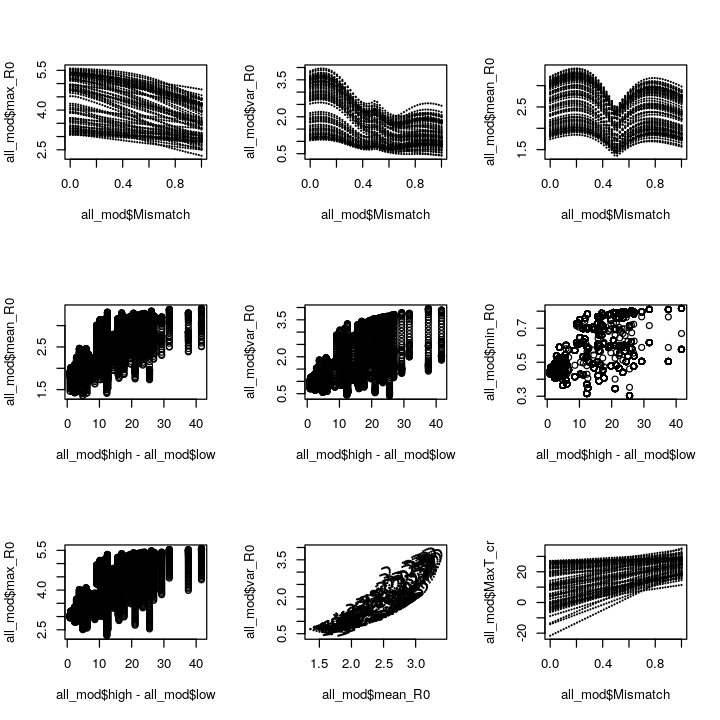

In [25]:
options(repr.plot.width=6, repr.plot.height=6)
par(mfrow=c(3,3))

#non latitude plots
plot(all_mod$Mismatch,all_mod$`max_R0`,cex=0.1)
plot(all_mod$Mismatch,all_mod$`var_R0`,cex=0.1)
plot(all_mod$Mismatch,all_mod$`mean_R0`,cex=0.1)
plot(all_mod$high-all_mod$low,y=all_mod$mean_R0)
plot(all_mod$high-all_mod$low,y=all_mod$var_R0)
plot(all_mod$high-all_mod$low,y=all_mod$min_R0)
plot(all_mod$high-all_mod$low,y=all_mod$max_R0)
  
plot(y=all_mod$`var_R0`,all_mod$`mean_R0`,cex=0.1)
plot(all_mod$Mismatch,all_mod$`MaxT_cr`,cex=0.1)
 


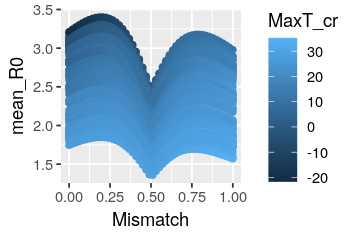

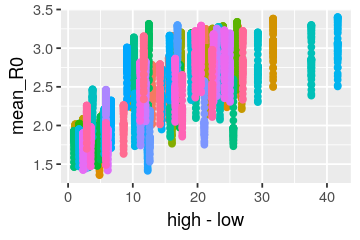

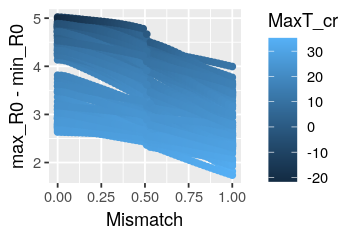

In [26]:
options(repr.plot.width=3, repr.plot.height=2)
ggplot(data=all_mod,aes(Mismatch,mean_R0,col=MaxT_cr)) + geom_point()
#when maxT_cr is higher, whole thing lower
ggplot(data=all_mod,aes(high-low,mean_R0,col=country))+geom_point() + theme(legend.position = "none") 

ggplot(data=all_mod,aes(Mismatch,max_R0-min_R0,col=MaxT_cr)) + geom_point()  

# Mismatch and difference between expected and observed flu peak

In [29]:


time=seq(00,365,length.out =365)
Climate_Variables= list(time_at_peak=NA,range_C=c(NA,NA),Max_Climate_cr=NA)
parms = list( mu = 2.06e-5,sigma = 0.68 ,p = 0.005, gamma =0.25,
             N = 1, nu = 5.07e-5, h=0.25 / 24 ,epsilon= 0.05, d=4/24,Max_cr=29.97,climate_label="Temperature",g=0.085,q0=-9.079,Climate_Variables=Climate_Variables, f=0.1)
start = c(S = (1-1e-3)*parms[["N"]],
          E = 0.00*parms[["N"]],
          I =(1e-3)*parms[["N"]],
          R = 0*parms[["N"]],
          N  = parms[["N"]])
len_contact=30
out_list<-list()
latitude_data_mod<-latitude_data[sort(rep(1:nrow(latitude_data),len_contact)),]
latitude_data_mod$max_time<-NA
latitude_data_mod$max_I<-NA
latitude_data_mod$Max_T_Cr<-NA
latitude_data_mod$Mismatch<-NA
latitude_data_mod$peak_diff<-NA
latitude_data_mod$Max_T_Cl<-NA
index<-1
for (i in 1:nrow(latitude_data)){
  parms_temp<-parms
  parms_temp[["Climate_Variables"]][["range_C"]]<-c(latitude_data$low[i],latitude_data$high[i])
  parms_temp[["Climate_Variables"]][["time_at_peak"]]<-latitude_data$peak[i]
  Climate_Range<-seq(latitude_data$low[i],latitude_data$high[i],length.out = len_contact)
  Climate_Peak<-latitude_data$low[i]
  
    for (j in Climate_Range){
    
        parms_temp[["Climate_Variables"]][["Max_Climate_cr"]]<-j
        temp<-ode(    y = start,    time = time,    func = SEIR_model,    parms = parms_temp )
        latitude_data_mod$max_time[index]<-temp[which.max(temp[,"I"]),"time"]
        latitude_data_mod$max_I[index]<-max(temp[,"I"])
        latitude_data_mod$Max_T_Cr[index]<-j
        latitude_data_mod$Max_T_Cl[index]<-Climate_Peak
        latitude_data_mod$Mismatch[index]<-(j-Climate_Peak)/(max(Climate_Range)-min(Climate_Range))
        latitude_data_mod$peak_diff[index]<-abs(temp[which.max(temp[,"I"]),"time"]-flu_data$peak[i])
        out_list[[paste0(as.character(latitude_data$country[i]),j)]] = temp
        index<-index+1
  }
}
index

[1] 2371

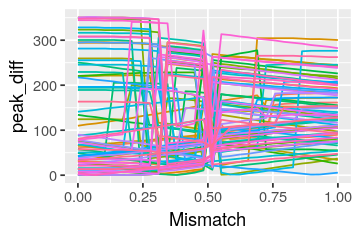

In [30]:
ggplot(data=latitude_data_mod,aes(x=Mismatch,y=peak_diff, col=country,group= country,))+geom_line() +theme(legend.position="none")

## results depend on time interval chosen

In [31]:
time=seq(100,465,length.out =365)
Climate_Variables= list(time_at_peak=NA,range_C=c(NA,NA),Max_Climate_cr=NA)
parms = list( mu = 2.06e-5,sigma = 0.68 ,p = 0.005, gamma =0.25,
             N = 1, nu = 5.07e-5, h=0.25 / 24 ,epsilon= 0.03, d=4/24,Max_cr=29.97,climate_label="Temperature",g=0.085,q0=-9.079,Climate_Variables=Climate_Variables)
start = c(S = (1-1e-3)*parms[["N"]],
          E = 0.00*parms[["N"]],
          I =(1e-3)*parms[["N"]],
          R = 0*parms[["N"]],
          N  = parms[["N"]])
len_contact=30
out_list<-list()
latitude_data_mod<-latitude_data[sort(rep(1:nrow(latitude_data),len_contact)),]
latitude_data_mod$max_time<-NA
latitude_data_mod$max_I<-NA
latitude_data_mod$Max_T_Cr<-NA
latitude_data_mod$Mismatch<-NA
latitude_data_mod$peak_diff<-NA
latitude_data_mod$Max_T_Cl<-NA
index<-1
for (i in 1:nrow(latitude_data)){
  parms_temp<-parms
  parms_temp[["Climate_Variables"]][["range_C"]]<-c(latitude_data$low[i],latitude_data$high[i])
  parms_temp[["Climate_Variables"]][["time_at_peak"]]<-latitude_data$peak[i]
  Climate_Range<-seq(latitude_data$low[i],latitude_data$high[i],length.out = len_contact)
  Climate_Peak<-latitude_data$low[i]
  for (j in Climate_Range){
      parms_temp[["Climate_Variables"]][["Max_Climate_cr"]]<-j
      temp<-ode(    y = start,    time = time,    func = SEIR_model,    parms = parms_temp )
      latitude_data_mod$max_time[index]<-temp[which.max(temp[,"I"]),"time"]
      latitude_data_mod$max_I[index]<-max(temp[,"I"])
      latitude_data_mod$Max_T_Cr[index]<-j
      latitude_data_mod$Max_T_Cl[index]<-Climate_Peak
      #latitude_data_mod$Mismatch[index]<-abs((j-Climate_Peak)/(min(Climate_Range)-max(Climate_Range)))
      latitude_data_mod$Mismatch[index]<-(j-Climate_Peak)/(max(Climate_Range)-min(Climate_Range))
      latitude_data_mod$peak_diff[index]<-abs(temp[which.max(temp[,"I"]),"time"]-flu_data$peak[i])
      out_list[[paste0(as.character(latitude_data$country[i]),index)]] = temp
      index<-index+1
  }
}
index

ERROR: Error in func(time, state, parms, ...): object 'f' not found


In [ ]:
for ( i in 1:nrow(latitude_data_mod)){
    if (latitude_data_mod$peak_diff[i]> 365){
        latitude_data_mod$peak_diff[i]<-latitude_data_mod$peak_diff[i]-365
    }
}


In [ ]:
ggplot(data=latitude_data_mod,aes(x=Mismatch,y=peak_diff, col=country,group= country,))+geom_line() +theme(legend.position="none")

In [ ]:
latitude_data_mod<-latitude_data[sort(rep(1:nrow(latitude_data),30)),]
latitude_data_mod$max_time<-NA
latitude_data_mod$max_I<-NA
latitude_data_mod$Max_Cr<-NA

for (k in 1:nrow(latitude_data_mod)){
    temp<-out_list[[latitude_data_mod[k,"country"]]]
    latitude_data_mod$max_time[j]<-temp[which.max(temp[,"I"]),"time"]
    latitude_data_mod$max_I[j]<-max(temp[,"I"])

}

# R0 and values over time

In [ ]:
options(repr.plot.width=6, repr.plot.height=8)

panel_plot<-function(parms){
  out = ode(    y = start,    time = time,    func = SEIR_model,    parms = parms )
  plot(x = out[, "time"], y= out[, "S"], ylab = "Number", xlab = "Time",
       type = "l", xlim=c(min(time), max(time)),ylim=c(0,  max(out[, "N"])))
  lines(x = out[, "time"],y= out[, "E"], col = "orange")
  lines(x = out[, "time"],y= out[, "I"], col = "red",lwd=3)
  lines(x = out[, "time"],y= out[, "R"], col = "green")
  lines(x = out[, "time"],y= out[, "N"], col = "purple")  
  abline(h = max(out[,"I"]),lty=3,col="red")
  legend( "topright",legend = c("S", "E", "I", "R","N","Max I"), 
          col = c("black", "orange", "red", "green","purple","red"), lty = c(1,1,1,1,1,3), cex = 0.8)
  
  maxpercent=max(( out[, "I"]/ out[, "N"])*100)
  maximum= paste("Maximum I is:",round(maxpercent,digits = 2),"%")
  text(max(time)/2, max(out[, "N"]),maximum)   

   
  Climate_Time<-Climate_Time_Function(time=time,min = parms[["Climate_Variables"]][["range_C"]][1],max= parms[["Climate_Variables"]][["range_C"]][2],time_at_peak = parms[["Climate_Variables"]][["time_at_peak"]])   

  R_0<-find_R0_function(Climate=Climate_Time,parms=parms,Climate_Variables_Temp = parms[["Climate_Variables"]], max_R0_Req="False")
  plot(time,R_0)
}


## Varying the temperature at which contact peaks

In [ ]:
time = seq(0,365, by = 0.1)
start = c(S = (1-1e-3),
          E = 0.00,
          I =(1e-3),
          R = 0,
          N  =1)
par(mfrow=c(3,2))
Climate_Variables= list(time_at_peak=latitude_data[77,"peak"],range_C=c(latitude_data[77,"low"],latitude_data[77,"high"]),Max_Climate_cr=NA)
parms = list( mu = 2.06e-5,sigma = 0.68 ,p = 0.005, gamma =0.25,
             N = 1, nu = 5.07e-5, h=0.25 / 24 ,epsilon= 0.05, d=4/24,Max_cr=29.97,climate_label="Temperature",g=0.085,q0=-9.079,Climate_Variables=Climate_Variables)
contact_peak<-c(latitude_data[77,"low"],(latitude_data[79,"high"]-latitude_data[77,"low"])/2,latitude_data[77,"high"])
for (i in 1:length(contact_peak)){
    parms[["Climate_Variables"]][["Max_Climate_cr"]]<-contact_peak[i]
    panel_plot(parms)

    }




# Changing Time interval can have a large effect

In [ ]:
par(mfrow=c(3,2))

Climate_Variables= list(time_at_peak=latitude_data[77,"peak"],range_C=c(latitude_data[77,"low"],latitude_data[77,"high"]),Max_Climate_cr=latitude_data[79,"high"])
parms = list( mu = 2.06e-5,sigma = 0.68 ,p = 0.005, gamma =0.25,
             N = 1, nu = 5.07e-5, h=0.25 / 24 ,epsilon= 0.05, d=4/24,Max_cr=29.97,climate_label="Temperature",g=0.085,q0=-9.079,Climate_Variables=Climate_Variables)
time = seq(0,365, by = 0.1)
start = c(S = (1-1e-3)*1,
          I =(1e-3)*1,
          E = 0.00*1,
          R = 0*1,
          N  = 1)
panel_plot(parms)
time = seq(100,465, by = 0.1)
panel_plot(parms)

## Smaller initial value delays peak and slightly increases size of peak (unless starts very high)

In [ ]:
par(mfrow=c(3,2))
time = seq(0,250, by = 0.1)
Climate_Variables= list(time_at_peak=latitude_data[77,"peak"],range_C=c(latitude_data[77,"low"],latitude_data[77,"high"]),Max_Climate_cr=latitude_data[79,"high"])
parms = list( mu = 2.06e-5,sigma = 0.68 ,p = 0.005, gamma =0.25,
             N = 1, nu = 5.07e-5, h=0.25 / 24 ,epsilon= 0.05, d=4/24,Max_cr=29.97,climate_label="Temperature",g=0.085,q0=-9.079,Climate_Variables=Climate_Variables)
I_Vec<-c(1e-1,1e-2,1e-3,1e-4,1e-5)
for (i in 1:length(I_Vec)){
    start =start = c(S = (1-I_Vec[i])*1,
          I =I_Vec[i],
          E= 0.0,
          R = 0,
          N  = 1)
    panel_plot(parms)

}


## Different ranges (i.e different countries)

In [ ]:
par(mfrow=c(3,2))
start = c(S = (1-1e-3)*1,
          I =(1e-3)*1,
          E = 0.00*1,
          R = 0*1,
          N  = 1)
time = seq(0,365, by = 0.1)
shorter<-latitude_data[c(7,27,47,67,77),]
parms = list( mu = 2.06e-5,sigma = 0.68 ,p = 0.005, gamma =0.25,
             N = 1, nu = 5.07e-5, h=0.25 / 24 ,epsilon= 0.05, d=4/24,Max_cr=29.97,climate_label="Temperature",g=0.085,q0=-9.079,Climate_Variables=Climate_Variables)
for (i in 1:nrow(shorter)){
    print(shorter[i,"country"])
    parms[["Climate_Variables"]][["time_at_peak"]]<-shorter[i,"peak"]
    parms[["Climate_Variables"]][["range_C"]]<-c(shorter[i,"low"],shorter[i,"high"])
    parms[["Climate_Variables"]][["Max_Climate_cr"]]<-shorter[i,"high"]
    panel_plot(parms)

    }

# Estimates for sensitivity analysis

In [32]:
means<-c(mean(latitude_data$low),mean(latitude_data$high))
means

[1] 10.27041 24.54261

In [35]:
cr_climate(Max_Coordinates_cr = c(means[1],parms[["Max_cr"]]),range_C =means,Climate=mean(means))

[1] 18.54123

In [36]:
q_climate(q0=parms[["q0"]],g=parms[["g"]],Climate=mean(means))

[1] -39.86575